# Classifier Models

In this notebook we will use the MNIST dataset. Let's load this in notebook:

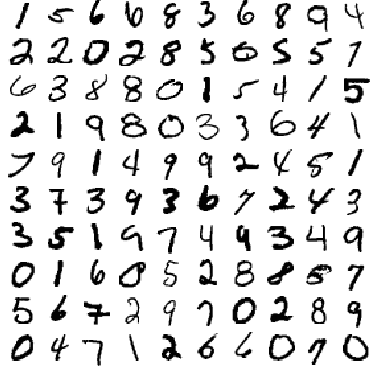

In [53]:
# Setup

import numpy as np
np.random.seed(42)

%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sn

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

In [54]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x.shape

(60000, 28, 28)

Let's take a look on MNIST data:

In [55]:
X = np.vstack((train_x, test_x))
X = X.reshape([-1 , 28*28])

y = np.append(train_y, test_y)

print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


In ```X``` we have 7000 instances and 784 (28 x 28 picture) features. 

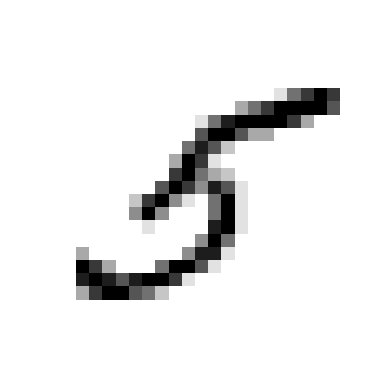

In [56]:
some_digit = X[35]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

This digit is clearly like a five, and this is! Check the y label in the same position:

In [57]:
y[35]

5

MNIST dataset is already divide in test and train set (the first 60.000 instances is the training test)

In [58]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print('X_train.shape :', X_train.shape)
print('X_test.shape :', X_test.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)

X_train.shape : (60000, 784)
X_test.shape : (10000, 784)
y_train.shape : (60000,)
y_test.shape : (10000,)


Let's shuffle the training set; this will ensure that all subsets
of the cross-validation are similar (so you make sure that no subset
is missing a digit).

## Training a Binary Classifier

Let's simplify the problem for the moment and just try to identify one digit - for example, the number 5. This "5-detector" will be an example of a binary classifier capable of distinguishing only between two classes: 5 and not 5.
5 and not 5. Let's create the target vectors for this classification task
classification task:

In [59]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Okay, now let's choose a classifier and train it. A good place to start is with
a *Stochastic Descent Gradient* (SGD) classifier using the
SGDClassifier class from Scikit-Learn. This classifier has the advantage that it can handle
efficiently with very large data sets. This is due in part to the fact that
SGD independently handles training instances one at a time.

In [60]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [61]:
sgd_clf.predict([some_digit])
# Some digit was a 5.

array([ True])

## Performance Measurement

Evaluating a classifier is often significantly more complicated than evaluating a regressor.
evaluating a regressor, so we will spend a large part of this notebook on this topic. There are many performance measurements available.

### Cross Validation Score (Accuracy)

In [62]:
# Here a code that does the same thing then CVS, but given more control for programmer:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred)) 

0.09795
0.09805
0.0976


The *StratifiedKFold* class performs stratified sampling to produce subsets that contain a representative proportion of each class.
each class. In each iteration, the code creates a clone of the classifier, trains that clone
in the training part, and makes predictions in the test part. It then counts the number of correct
correct predictions and outputs the proportion of correct predictions.

In our case, we will utilize the *cross_val_score( )* function to evalute this SGDClassifier Model, utilizing the cross validation in three parts of *K-fold*. 

>> Remember that K-fold cross-validation
K-fold cross-validation means dividing the training set into K-folds (in this case, three),
predict and evaluate the predictions on each set using a model trained on the remaining K-folds.
together on the remaining K-folds 

In [63]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9681 , 0.95655, 0.95515])

We got a 96% of accuracy, great? No, isn't great. Let's do **the same thing using a weak classifier**:

In [64]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

90% of Accuracy. This occours because 10% of images is a "5", i.e. if you always says that the image is not a "5" you will tecnacally be correct in 90% of cases.

This demonstrates why accuracy for classifiers is generally not the preferred measure of performance, especially
especially when you are dealing with *asymmetric data sets* (i.e. when some classes are much more frequent than others).

### Confusion Matrix

One way to much better evaluate the performance of a classifier is to look at the
confusion matrix. The general idea is to count the number of times instances of class
A are classified as class B. For example, to find out the number of times the
classifier confused images of "5" with "3", you would look at the 5th row and 3rd column of the
of the confusion matrix.

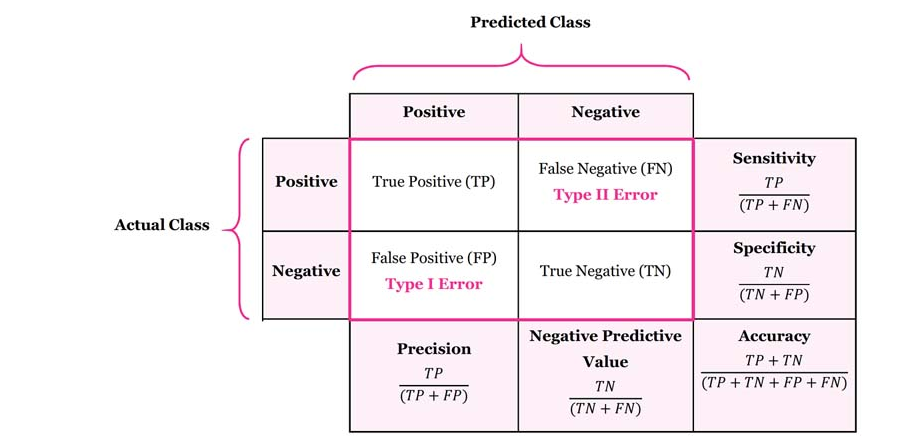

To calculate the confusion matrix, you first need to have a set of predictions
so that they can be compared with the actual targets. You can make predictions on the
test suite, but we will leave it untouched for now (remember that you
test suite only at the end of your project, when you have a classifier ready to launch).
classifier ready to launch). Instead, use the ``cross_val_predict( )`` function:

In [65]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

Like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but
K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each part of the test. This means that you get a clean prediction
prediction for each instance in the training set ("clean" meaning that the prediction is
made by a model that never saw the data during training).
Using the confusion_matrix() function, you are now ready to obtain the confusion matrix.
confusion matrix. Just pass the target classes (y_train_5 ) and the predicted classes ( y_train_pred):

In [66]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

precision = cm[1][1] / (cm[1][1] + cm[0][1]) # P = TP / (TP + FP)
recall = cm[1][1] / (cm[1][1] + cm[1][0]) # R = TP / (TP + FN)

print("Precision :", precision)
print("Recall :", revocation)

Precision : 0.754513244474439
Recall : 0.8249400479616307


The confusion matrix provides a lot of information, but sometimes you may prefer a more concise metric. One interesting thing to look at is the accuracy of the
positive predictions; this is called the accuracy of the classifier.

A trivial way to have perfect accuracy is to make a single positive prediction and
and guarantee that it is correct (accuracy = 1/1 = 100%). This would not be very useful since
the classifier would ignore all but one positive instance. Therefore, accuracy is
used in conjunction with another metric called revocation, also known as sensitivity
sensitivity or true positive rate (TPR): this is the rate of positive instances that are correctly
instances that are correctly detected by the classifier.

Here a example of the same code above, but using Scikit-Learn functions:

In [67]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.754513244474439

In [68]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)

0.8249400479616307

Now, his 5-detector doesn't look as bright as when you analyzed its accuracy.
When he says that an image represents a 5, he is correct only 75% of the
of the time. Moreover, it only detects 82% of the 5's.

It is often convenient to combine precision and revocation into a single metric called
F$_{1}$ score, especially if you need a simple way to compare two
classifiers. The F$_{1}$ score is the harmonic mean of precision and revocation. While the regular average treats all values equally, the harmonic average
gives much more weight to the lowest values. As a result, the classifier will only get
a high F$_{1}$ score only if both revocation and precision are high.

$$
F_{1} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision + recall}} = \frac{\text{TP}}{\text{TP} + \frac{\text{FN + FP}}{2}} 
$$

In [69]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7881565033486078

The F$_{1}$ score favors classifiers with similar accuracy and revocation. This is not always what
is what you want: in some contexts, your concern is mainly with accuracy
and in other contexts you are really concerned with revocation. For example, if you have trained a
classifier to detect videos that are suitable for children, you would probably prefer a classifier that
would probably prefer a classifier that rejected too many good videos (low revocation) but kept only
(high accuracy); rather than a classifier that had much higher revocation, but kept only
revocation, but would allow some really bad videos to appear in its product (in such cases the
in its product (in such cases, it is necessary to add a human pipeline to verify the
selection of the video classifier). On the other hand, suppose you train a classifier
to detect bad guys in the security system's images: it is probably fine
if your classifier has an accuracy of only 30%, provided it has 99% revocation
(sure the security guards will get some false alerts, but almost all the thieves will be caught).
thieves will be caught).
Unfortunately, it is not possible to have both: increasing the accuracy reduces the revocation, and vice versa.
-versa. This is called precision/revocation compensation.

### Trade-off

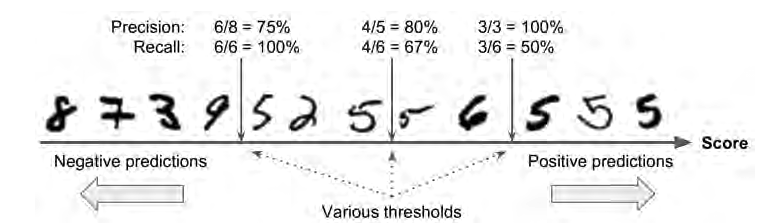

To understand this trade-off, let's look at how the SGDClassifier makes its classification decisions.
its classification decisions. For each instance, it calculates a score based on a decision function
decision function, and if this score is greater than a threshold, it assigns the instance to the posi
tive class, or it assigns it to the negative class. The figure above shows some digits positioned
from the lowest score on the left to the highest score on the right. Suppose
the decision threshold is positioned at the center arrow (between the two 5s): you will find
4 true positives (5 real ones) to the right of this threshold, and one false positive (actually a
6). So the accuracy is 80% (4 out of 5) at this threshold. But for every 6 out of 5 true positives,
the classifier only detects 4, so the revocation is 67% (4 out of 6). Now, if you increase the
threshold (move it to the right arrow) the false positive (the 6) becomes a true negative, thus increasing the accuracy (up to 100% in this case), but a true positive becomes
a false negative, decreasing the revocation to 50%. Thus, lowering the threshold increases
revocation and reduces precision.

Scikit-Learn does not allow you to set the threshold directly, but gives you access to the
decision scores that it uses to make predictions. Instead of calling the classifier's
predict( ) method of the classifier, you can call the decision_function( ) method, which returns a score for each instance and then makes predictions based on those
scores using any desired threshold:

In [70]:
y_scores = sgd_clf.decision_function([some_digit])

threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold of 0, so the preceding code returns the same
result as the predict() method (i.e., True ). We will increase the threshold:

In [71]:
threshold = -200000
y_some_digit_pred = (y_scores < threshold)
y_some_digit_pred

array([False])

So how can you decide which threshold to use? To do this, again using the
cross_val_predict() function, you will first need to get the scores of all the instances in the training
instances in the training set, but this time specifying that you want it to
return decision scores rather than predictions:

In [72]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5 , y_scores)

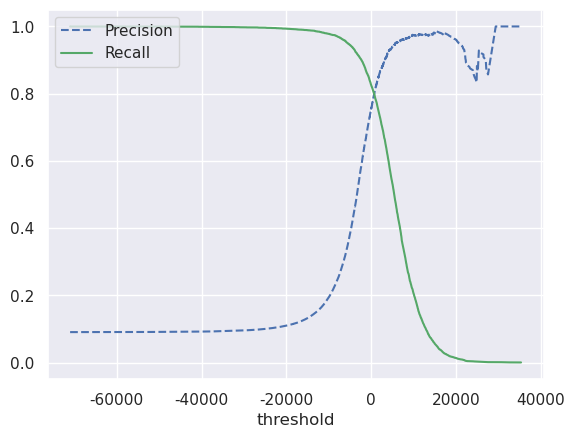

In [78]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("threshold")
    plt.legend(loc="upper left")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

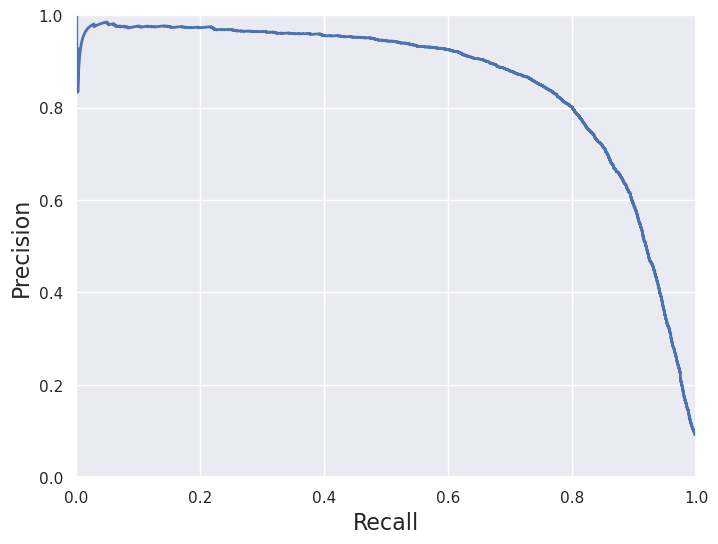

In [79]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

You can see that accuracy really starts to drop sharply around
at 80% revocation. You will probably select a precision/
revocation compensation before this drop - for example, around 60% revocation. But, of course
of course, the choice depends on your design.
So let's suppose you aim for 90% accuracy. You look at the first plot
(approximating it a bit) and find that you need to use a threshold of about 70,000.
Instead of calling the predict() method of the classifier, you can just run this
code to make predictions (for now, on the training set):

In [81]:
y_train_pred_90 = (y_scores > 11000)

precision_score(y_train_5, y_train_pred_90)

0.9743303571428571

In [82]:
recall_score(y_train_5, y_train_pred_90)

0.16104039845047038

### ROC curve

The receiver operating characteristics curve (ROC) is another common tool used with binary classifiers.
tool used with binary classifiers. It is very similar to the precision/
revocation curve, but instead of plotting precision versus revocation, the ROC curve plots the rate of true positives
(another name for revocation) versus the false positive rate (FPR).
false positives (FPR). The FPR is the ratio of negative instances incorrectly
incorrectly classified as positive. It is equal to 1 minus the true negative rate (TNR), which
which is the ratio of negative instances that are correctly classified as negative.
negative. The TNR is also called specificity. Therefore, the ROC curve plots
sensitivity (recall) versus 1 - specificity.

In [87]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

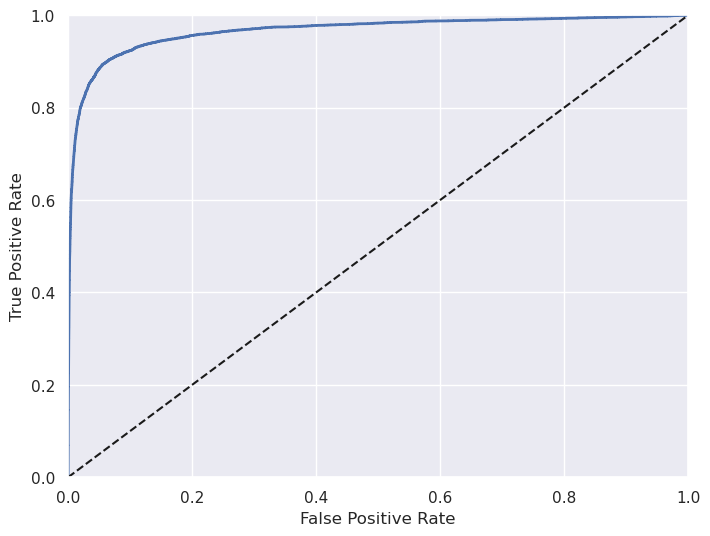

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.axis([0, 1, 0, 1])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have an ROC AUC equal to 1, while a purely random
A perfect classifier will have an ROC AUC equal to 1, while a purely random classifier will have an ROC AUC equal to 0.5. Scikit-Learn provides a function
function to calculate the ROC AUC:

In [89]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660259463088996

>> Since the ROC curve is so similar to the precision/revocation curve
(PR) curve, you may wonder how to decide which one to use. Like
general rule, you should prefer the PR curve whenever a positive class is rare or when you are more concerned about false positives
than false negatives, and the ROC curve otherwise.
For example, looking at the previous ROC curve (and the ROC
AUC), you might think that the classifier is really good. But
this is because there are some positive aspects (5) compared to the negative ones (not 5). In contrast, the PR curve makes it clear
that the classifier can improve (the curve could be closer to the upper right corner).

We will train a RandomForestClassifier and compare its ROC curve and the
ROC AUC score for the SGDClassifier . First, you need to get scores for each instance in the training set. But because of the way it works, the RandomForestClassifier class does not have a decision_function() method. At
Instead, it has a predict_probability() method. Scikit-Learn classifiers usually have one or the other.
classifiers usually have one or the other. The predict_proba() method returns an array that contains
one row per instance and one column per class, each containing the probability that the given
that the given instance belongs to the given class (for example, a 70% chance that the image
represents a 5):

In [93]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

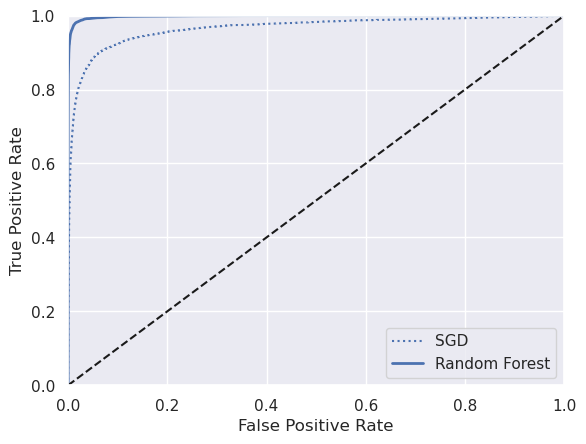

In [96]:
# But to plot a ROC curve, you need scores, not probabilities. A simple
# simple solution is to use the probability of the positive class as the score:

y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.legend(loc="lower right")

In [97]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

By now you probably know how to train binary classifiers, choose the appropriate
appropriate for your task, evaluate your classifiers using cross-validation
select the precision/revocation trade-off that matches your needs
and compare various models using ROC curves and ROC AUC scores. Now,
we will try to detect more than just the 5.

## Multiclass Classification

While binary classifiers can distinguish between two classes, multiclass classifiers
classifiers (also called *multinomial classifiers*) can distinguish between more
more than two classes.

Some algorithms (such as Random Forest or Naive-Bayes classifiers) are capable of handling multiple classes directly.
Naive-Bayes classifiers) are able to deal directly with multiple classes. Others (such as
Support Vector Machines* or Linear classifiers) are strictly binary. However, there are several strategies that you can use to perform
multi-class classification with multiple binary classifiers.

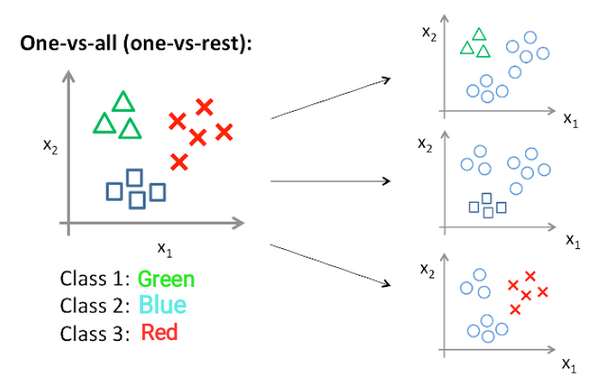

For example, one way to create a system that can classify numerical images
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (0-of
tector, 1-detector, 2-detector, and so on). So when you want to classify
you get the decision score of each classifier for this image and select the class whose
gem and select the class whose classifier produces the highest score. This is called
This is called the one-versus-all (OvA) strategy (also called *one-versus-the-rest*).

Another strategy is to train a binary classifier for each pair of digits: one for
distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called a one-to-one (OvO) strategy. If there are N classes, you
need to train N × (N - 1) / 2 classifiers. This means training 45 binary
binary classifiers for the MNIST problem! When we classify an image we must
run it through all 45 classifiers and see which class wins the most duels.
The main advantage of OvO is that each classifier needs to be trained only for
the two classes it has to distinguish on the training set part.

$$
\binom{N}{2} = \frac{N!}{2! \left(N-2\right)!} = \frac{N \times \left( N-1 \right)}{2}
$$ 

Some algorithms (such as the Support Vector Machines classifiers) scale poorly with the
with the size of the training set, so for these algorithms OvO
is better, since it is faster to train many classifiers on small sets than to train a few classifiers on large sets.
than to train a few classifiers on large sets. However, OvA is best
for most binary classification algorithms.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi-class classification task, and automatically runs OvA
(except for SVM classifiers, for which it uses OvO). 

In [98]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

Behind the scenes, the
Scikit-Learn actually trained 10 binary classifiers, got their decision score for the image
decision score for the image, and selected the class with the highest score.

To see that this is actually the case, we will call the ``decision_function( )`` method. At
instead of returning just one score per instance, it now returns 10 scores,
one per class:

In [100]:
some_digit_scores = sgd_clf.decision_function([some_digit])

some_digit_scores

array([[-19239.63627687,  -9174.6116144 ,  -5318.75048476,
         -2030.92952005, -13130.37149922,   1956.94179539,
        -10736.69611255, -20064.60500473,  -4379.59593076,
         -9106.26421666]])

In [101]:
np.argmax(some_digit_scores)

5

If you want to force Scikit-Learn to use *one against one* or *one against all*, you can
use the ``OneVsOneClassifier`` class or the ``OneVsRestClassifier`` class. Create an instance and
pass a binary classifier to its constructor. For example, using the
OvO, based on ```SGDClassifier```, this code creates a multiclass classifier:

In [102]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(max_iter=5, random_state=42))

In [103]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [104]:
len(ovo_clf.estimators_)

45

This time, Scikit-Learn didn't need to run OvA or OvO because the Random Forest
can classify instances directly into multiple classes. You
can call ``predict_proba( )`` to get the list of probabilities that the classifier
has assigned to each instance for each class:

In [105]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [106]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.03, 0.  , 0.95, 0.  , 0.  , 0.01, 0.  ]])

Now, of course, you must evaluate these classifiers. As usual, use
cross-validation. Let's evaluate the accuracy of the SGDClassifier using the function
``cross_val_score()`` function:

In [107]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8678 , 0.88195, 0.86965])

It gets above 80% in all parts of the test. If you use a random
you get 10% accuracy, so it's not such a bad score, but you can still
can improve. For example, scaling the inputs increases the accuracy by more than
90%:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analysis